This notebook is built and tested in Google Colab

In [81]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pytorch-forecasting ta optuna statsmodels optuna-integration[pytorch_lightning]

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.7/197.7 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:

In [ ]:
import os
import ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import torch
import pytorch_lightning as pl

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer, TorchNormalizer
from pytorch_forecasting.metrics import SMAPE
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

# TODO: Fill in the Google Drive path where you uploaded assignment1
# Example: If you create a Fall2023 folder and put all the files under A1 folder, then 'Fall2023/A1'
GOOGLE_DRIVE_PATH_POST_MYDRIVE = 'capstone_project'
user = 'ydosi3'
if user == 'ydosi3':
  GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive',
                                   'MyDrive/Colab Notebooks', GOOGLE_DRIVE_PATH_POST_MYDRIVE)
else:
  GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive', 'MyDrive',
                                   GOOGLE_DRIVE_PATH_POST_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

import sys
sys.path.append(GOOGLE_DRIVE_PATH)

os.environ['GOOGLE_DRIVE_PATH'] = GOOGLE_DRIVE_PATH

os.environ['GOOGLE_DRIVE_PATH']

['ydosi3-tft-pipeline.ipynb', 'data', 'utils', 'src', 'data_processing.ipynb', 'model', 'models_results', 'notebooks', '__pycache__', 'MarketSimulator.py', 'E2E_Pipeline.ipynb', 'E2E_Pipeline_manik.ipynb', 'ydosi3-deepar-pipeline.ipynb']


'/content/drive/MyDrive/Colab Notebooks/capstone_project'

In [ ]:
from utils.commons import *

# hyperparams
TRAINING_DATA_RATIO = 0.85
VALIDATION_DATA_RATIO = 0.15
# TESTING_DATA_RATIO = 0.1

data_base = f"{os.environ['GOOGLE_DRIVE_PATH']}/data"

merged_data = get_all_data(data_base)
merged_data["stock"] = "NIFTY_IDX"
merged_data = add_indicators(merged_data)
merged_data.dropna(axis=0, how='any', inplace=True)
# add index column
merged_data["time_idx"] = merged_data.index

In [ ]:
merged_data.head()

,min_date,open,high,low,close,hour,min_close_start,hourly_return,gap_percentage,gap_type,...,vix_close,stock,ema_slow,ema_fast,MACD,MACD_signal,MACD_diff,stoch,stoch_signal,time_idx
127,2015-01-09 11:22:00,8279.25,8280.70,8279.15,8280.60,11,8287.75,-0.000863,0.617516,no_gap,...,15.90,NIFTY_IDX,8284.689072,8283.160471,-1.984227,-1.712847,-0.271380,35.039370,24.015748,127
128,2015-01-09 11:23:00,8280.55,8280.60,8270.50,8270.50,11,8287.75,-0.002081,0.617516,no_gap,...,15.99,NIFTY_IDX,8284.454542,8282.745374,-2.280343,-1.826346,-0.453996,0.000000,19.816273,128
129,2015-01-09 11:24:00,8269.45,8271.30,8266.55,8266.55,11,8287.75,-0.002558,0.617516,no_gap,...,15.99,NIFTY_IDX,8284.158599,8282.214378,-2.663713,-1.993820,-0.669893,0.000000,11.679790,129
130,2015-01-09 11:25:00,8267.05,8267.05,8262.85,8264.30,11,8287.75,-0.002829,0.617516,no_gap,...,15.95,NIFTY_IDX,8283.830358,8281.627021,-3.083075,-2.211671,-0.871404,5.576923,1.858974,130
131,2015-01-09 11:26:00,8264.90,8268.35,8264.30,8266.40,11,8287.75,-0.002576,0.617516,no_gap,...,15.97,NIFTY_IDX,8283.542253,8281.127775,-3.418765,-2.453090,-0.965675,13.653846,6.410256,131


In [ ]:
train_df, val_df, test_df = create_train_val_test_split(
    df=merged_data, forecast_window=10, lookback_factor=5,
    forecast_start_date=pd.to_datetime('2022-04-01'),
    training_ratio=0.85,
)

/content/drive/MyDrive/Colab Notebooks/capstone_project/utils/commons.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["time_idx"] = train_df.index
/content/drive/MyDrive/Colab Notebooks/capstone_project/utils/commons.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df["time_idx"] = val_df.index
/content/drive/MyDrive/Colab Notebooks/capstone_project/utils/commons.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [ ]:
print("Close Column Statistics:")
print(f"Minimum: {train_df['close'].min()}")
print(f"Maximum: {train_df['close'].max()}")
print(f"Mean: {train_df['close'].mean()}")
print(f"Median: {train_df['close'].median()}")
# Calculate mode - it might have multiple modes
from scipy import stats
mode_result = stats.mode(train_df['close'])
# print(mode_result)
print(f"Mode: {mode_result.mode} (count: {mode_result.count})")


Close Column Statistics:
Minimum: 15674.25
Maximum: 18347.95
Mean: 17272.40018517566
Median: 17326.75
Mode: 15785.4 (count: 26)


In [ ]:
print("Close Column Statistics:")
print(f"Minimum: {val_df['close'].min()}")
print(f"Maximum: {val_df['close'].max()}")
print(f"Mean: {val_df['close'].mean()}")
print(f"Median: {val_df['close'].median()}")
# Calculate mode - it might have multiple modes
from scipy import stats
mode_result = stats.mode(val_df['close'])
# print(mode_result)
print(f"Mode: {mode_result.mode} (count: {mode_result.count})")

Close Column Statistics:
Minimum: 17006.9
Maximum: 17556.8
Mean: 17266.38870591664
Median: 17252.45
Mode: 17226.45 (count: 5)


In [ ]:
# TODO:
# These two will be known during the forecasting.
#   Add hourly metrics - they serve has more recent market sentiment (evoling during the day)
# Can we get all features and do a PCA over that?
# How can we use grouping? Does hourly grouping make sense? How is grouping useful in TFT?
# Will return till hour from open be a useful feature?
# Scaling

# Findings:
# min_close_start & hourly_return did not help - maybe it helps with the return_on_day column?

In [ ]:
from torchmetrics.regression import MeanSquaredError
from pytorch_forecasting.data import TimeSeriesDataSet
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scalers = {
    'open': MinMaxScaler(),
    'high': MinMaxScaler(),
    'low': MinMaxScaler(),
    # 'close': MinMaxScaler(),
    'vix_open': MinMaxScaler(),
    'vix_high': MinMaxScaler(),
    'vix_low': MinMaxScaler(),
    'vix_close': MinMaxScaler(),
    'RSI': MinMaxScaler(),
    'MACD': MinMaxScaler(),
    'MACD_signal': MinMaxScaler(),
    'MACD_diff': MinMaxScaler(),
    'stoch': MinMaxScaler(),
    'stoch_signal': MinMaxScaler(),
    'ema_slow': MinMaxScaler(),
    'ema_fast': MinMaxScaler(),
}

In [ ]:
from utils.lightning_utils import TFTLightningModule

max_encoder_length =    60 # experiment with higher input windows
max_prediction_length = 10 # forecast horizon (10 minutes)

training_data = TimeSeriesDataSet(
    train_df,
    time_idx="time_idx",
    target="close",
    group_ids=["stock"],
    # Fixed history and forecast lengths:
    min_encoder_length=max_encoder_length//2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=["gap_percentage"],
    time_varying_unknown_reals=['close', 'vix_close', 'ema_fast', 'hourly_return',
                                'MACD_signal', 'MACD_diff', 'stoch', 'stoch_signal', 'ema_slow'],
    target_normalizer=GroupNormalizer(
        groups=["stock"], transformation="softplus"
    ),
    allow_missing_timesteps=True,
    scalers=scalers,
    # add_relative_time_idx=True,
    # add_target_scales=True,
    # add_encoder_length=True,
)

# Create dataloaders for training and validation:
batch_size = calculate_batch_size(train_df.shape[0], 200)
print(f"Batch size: {batch_size}")
train_dataloader = training_data.to_dataloader(train=True, batch_size=batch_size, num_workers=0)

# Build the validation dataset from the same dataset (ensuring consistent preprocessing)
validation_data = TimeSeriesDataSet.from_dataset(
    training_data, val_df, stop_randomization=True, predict=True,
    min_encoder_length=max_encoder_length//2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length
)

valid_dataloader = validation_data.to_dataloader(batch_size=batch_size, num_workers=0, train=False)
l = "smape"
# ---------------------------
# 4. Build and train the TFT model
# ---------------------------
# We use TemporalFusionTransformer.from_dataset to auto-configure many model parameters.
tft = TemporalFusionTransformer.from_dataset(
    training_data,
    learning_rate=0.007,
    hidden_size=9,             # size of internal layers (tune based on your data)
    attention_head_size=7,      # number of attention heads
    dropout=0.05,
    hidden_continuous_size=9,   # dimensionality for continuous variable processing
    output_size=1,              # default output size (used for quantile forecasts)
    loss=MeanSquaredError() if l == "mse" else SMAPE(),               # Symmetric Mean Absolute Percentage Error
    log_interval=10,
    reduce_on_plateau_patience=4,
    causal_attention=True,
).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")

# Configure a PyTorch Lightning Trainer:
trainer = pl.Trainer(
    max_epochs=10,
    gradient_clip_val=0.75,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

# Create an instance of the Lightning module, wrapping the TFT model
tft_lightning_module = TFTLightningModule(tft)

Batch size: 128


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [57]:
# create study
study = optimize_hyperparameters(
    train_dataloader,
    valid_dataloader,
    model_path=f"{data_base}/hyperparam_tuning_test_with_scaling_small",
    n_trials=20,
    max_epochs=15,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(2, 50),
    hidden_continuous_size_range=(2, 50),
    attention_head_size_range=(2, 10),
    learning_rate_range=(0.001, 0.3),
    dropout_range=(0.01, 0.4),
    trainer_kwargs={
        "limit_train_batches":100,
        # "deterministic": True
    },
    reduce_on_plateau_patience=4,
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2025-04-29 05:20:40,814] A new study created in memory with name: no-name-2909c692-b512-4fe4-b127-87ae8915c3e8
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:142: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gradient_clip_val = trial.suggest_loguniform(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:168: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugg

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.002637002935827541
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.002637002935827541
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_394adb7b-cc87-4945-8a42-a7074676e3fc.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_394adb7b-cc87-4945-8a42-a7074676e3fc.ckpt
[I 2025-04-29 05:20:56,822] Using learning rate of 0.00313
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.hparams.learning_rate = trial.suggest_uniform(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_c

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0020990644001273556
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.0020990644001273556
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_d6e9386b-b99e-4920-9d11-b909138786c0.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_d6e9386b-b99e-4920-9d11-b909138786c0.ckpt
[I 2025-04-29 05:25:04,141] Using learning rate of 0.00198
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.hparams.learning_rate = trial.suggest_uniform(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0031291346445318983
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.0031291346445318983
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_7943d9a4-ab40-4aaa-969c-0ff31e056dcb.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_7943d9a4-ab40-4aaa-969c-0ff31e056dcb.ckpt
[I 2025-04-29 05:29:12,241] Using learning rate of 0.00313
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.hparams.learning_rate = trial.suggest_uniform(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.005535238985626912
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.005535238985626912
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_5164f985-6e84-4985-b495-3086aef796aa.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_5164f985-6e84-4985-b495-3086aef796aa.ckpt
[I 2025-04-29 05:30:00,426] Using learning rate of 0.00494
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.hparams.learning_rate = trial.suggest_uniform(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_c

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.006568255135542075
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.006568255135542075
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_65bfd24b-ba16-48ad-b81a-d1a66df7af5d.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_65bfd24b-ba16-48ad-b81a-d1a66df7af5d.ckpt
[I 2025-04-29 05:31:34,050] Using learning rate of 0.00736
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.hparams.learning_rate = trial.suggest_uniform(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_c

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.00979148362360977
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.00979148362360977
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_233a5b6c-0c95-440b-ae79-c161b0ae47ef.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_233a5b6c-0c95-440b-ae79-c161b0ae47ef.ckpt
[I 2025-04-29 05:32:20,360] Using learning rate of 0.0206
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.hparams.learning_rate = trial.suggest_uniform(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_chec

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0024908031183062877
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.0024908031183062877
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_b7d65555-6137-49df-956c-f17e798fe24e.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_b7d65555-6137-49df-956c-f17e798fe24e.ckpt
[I 2025-04-29 05:33:04,078] Using learning rate of 0.0244
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.hparams.learning_rate = trial.suggest_uniform(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.013022805810412262
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.013022805810412262
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_6ba57ab5-0ead-4be6-8127-726e98c11b7f.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_6ba57ab5-0ead-4be6-8127-726e98c11b7f.ckpt
[I 2025-04-29 05:37:07,865] Using learning rate of 0.0146
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.hparams.learning_rate = trial.suggest_uniform(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_ch

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0031291346445318983
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.0031291346445318983
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_b500bd4f-5d37-4836-95fd-4b9a7ed1de7e.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_b500bd4f-5d37-4836-95fd-4b9a7ed1de7e.ckpt
[I 2025-04-29 05:37:54,766] Using learning rate of 0.00351
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.hparams.learning_rate = trial.suggest_uniform(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0024908031183062877
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.0024908031183062877
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_7b96ce30-24b3-4022-971a-e3a31abc6a54.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_7b96ce30-24b3-4022-971a-e3a31abc6a54.ckpt
[I 2025-04-29 05:38:43,553] Using learning rate of 0.00222
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.hparams.learning_rate = trial.suggest_uniform(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0018727652318237316
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.0018727652318237316
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_f5d27f40-82fc-4109-9126-d21eb752924b.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_f5d27f40-82fc-4109-9126-d21eb752924b.ckpt
[I 2025-04-29 05:39:32,877] Using learning rate of 0.00187
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.hparams.learning_rate = trial.suggest_uniform(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.027335708066408046
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.027335708066408046
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_28088044-5767-4cbf-b3e0-532b4fd8565f.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_28088044-5767-4cbf-b3e0-532b4fd8565f.ckpt
[I 2025-04-29 05:40:23,514] Using learning rate of 0.0244
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.hparams.learning_rate = trial.suggest_uniform(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_ch

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.005535238985626912
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.005535238985626912
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_5de0ef63-e709-44cb-b145-40ccbbc0a57a.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_5de0ef63-e709-44cb-b145-40ccbbc0a57a.ckpt
[I 2025-04-29 05:41:09,438] Using learning rate of 0.00494
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.hparams.learning_rate = trial.suggest_uniform(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_c

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.002637002935827541
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.002637002935827541
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_efbd17f8-abc6-4291-95de-dd7f31e95ea6.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_efbd17f8-abc6-4291-95de-dd7f31e95ea6.ckpt
[I 2025-04-29 05:42:41,546] Using learning rate of 0.00187
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.hparams.learning_rate = trial.suggest_uniform(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_c

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.014596441455605227
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.014596441455605227
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_8d4273d6-c2b6-4c0e-807c-dd246aabe1a2.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_8d4273d6-c2b6-4c0e-807c-dd246aabe1a2.ckpt
[I 2025-04-29 05:43:31,640] Using learning rate of 0.013
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.hparams.learning_rate = trial.suggest_uniform(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_che

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.003713110626680822
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.003713110626680822
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_ad67e09f-a1b7-470f-982a-bfaa8f14b5ae.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_ad67e09f-a1b7-470f-982a-bfaa8f14b5ae.ckpt
[I 2025-04-29 05:44:16,821] Using learning rate of 0.00416
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.hparams.learning_rate = trial.suggest_uniform(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_c

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0024908031183062877
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.0024908031183062877
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_346dca12-5f2d-4b02-8a44-9c710a2a1d6a.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_346dca12-5f2d-4b02-8a44-9c710a2a1d6a.ckpt
[I 2025-04-29 05:45:03,807] Using learning rate of 0.0062
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.hparams.learning_rate = trial.suggest_uniform(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0018727652318237316
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.0018727652318237316
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_0895ecfb-a97c-4790-89e7-dcf6401ad5f9.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_0895ecfb-a97c-4790-89e7-dcf6401ad5f9.ckpt
[I 2025-04-29 05:45:51,622] Using learning rate of 0.00187
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.hparams.learning_rate = trial.suggest_uniform(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.012300799851590868
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.012300799851590868
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_392cc885-a340-480b-ae71-37abf739a863.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_392cc885-a340-480b-ae71-37abf739a863.ckpt
[I 2025-04-29 05:46:39,894] Using learning rate of 0.0123
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.hparams.learning_rate = trial.suggest_uniform(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_ch

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0020990644001273556
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.0020990644001273556
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_eddfafcd-0a3f-41bd-87c4-2ecc0082a99a.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_eddfafcd-0a3f-41bd-87c4-2ecc0082a99a.ckpt
[I 2025-04-29 05:47:25,097] Using learning rate of 0.00249
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.hparams.learning_rate = trial.suggest_uniform(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model

{'gradient_clip_val': 0.01853614406550999, 'hidden_size': 32, 'dropout': 0.1211234064940099, 'hidden_continuous_size': 2, 'attention_head_size': 6, 'learning_rate': 0.001982688787459456}


In [58]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")

l = "smape"
new_tft = TemporalFusionTransformer.from_dataset(
    training_data,
    learning_rate=study.best_trial.params["learning_rate"],
    hidden_size=study.best_trial.params["hidden_size"], # size of internal layers (tune based on your data)
    attention_head_size=study.best_trial.params["attention_head_size"], # number of attention heads
    dropout=study.best_trial.params["dropout"],
    hidden_continuous_size=study.best_trial.params["hidden_continuous_size"], # dimensionality for continuous variable processing
    output_size=1,              # default output size (used for quantile forecasts)
    loss=MeanSquaredError() if l == "mse" else SMAPE(),
    log_interval=10,
    reduce_on_plateau_patience=4,
    causal_attention=True,
).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Configure a PyTorch Lightning Trainer:
trainer = pl.Trainer(
    max_epochs=20,
    gradient_clip_val=study.best_trial.params["gradient_clip_val"],
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

new_tft_lightning_module = TFTLightningModule(new_tft)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [60]:
# Train the model:
trainer.fit(
    new_tft_lightning_module,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader,
)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                      | Params | Mode 
------------------------------------------------------------
0 | model | TemporalFusionTransformer | 57.8 K | train
------------------------------------------------------------
57.8 K    Trainable params
0         Non-trainable params
57.8 K    Total params
0.231     Total estimated model params size (MB)
316       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(f"Best model path: {best_model_path}")
best_model = TFTLightningModule.load_from_checkpoint(best_model_path, tft=new_tft)

In [62]:
import os
# Save the trained model
model_save_path = f"{GOOGLE_DRIVE_PATH}/models_results/checkpoints/ydosi3-tft-v8.ckpt"
trainer.save_checkpoint(model_save_path)
print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/MyDrive/Colab Notebooks/capstone_project/models_results/checkpoints/ydosi3-tft-v23.ckpt


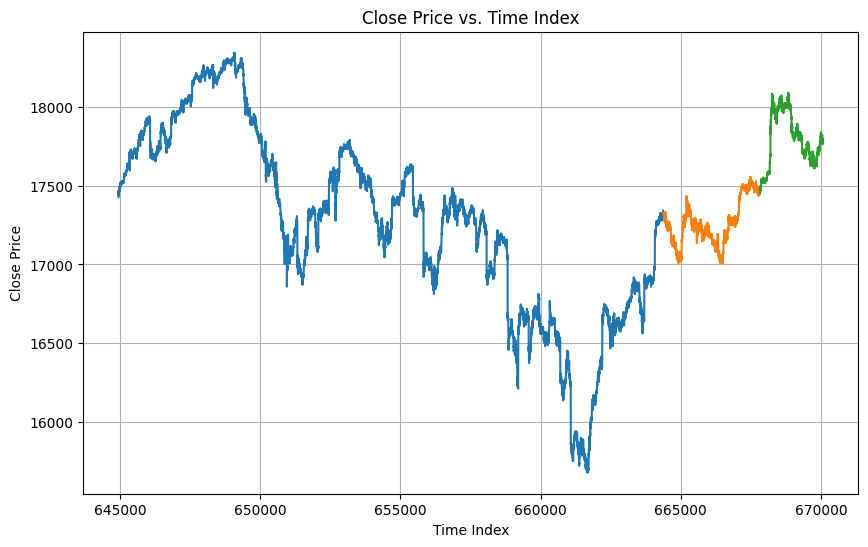

In [63]:
plt.figure(figsize=(10, 6))
plt.plot(train_df['time_idx'], train_df['close'])
plt.plot(val_df['time_idx'], val_df['close'])
plt.plot(test_df['time_idx'], test_df['close'])
plt.xlabel('Time Index')
plt.ylabel('Close Price')
plt.title('Close Price vs. Time Index')
plt.grid(True)
plt.show()

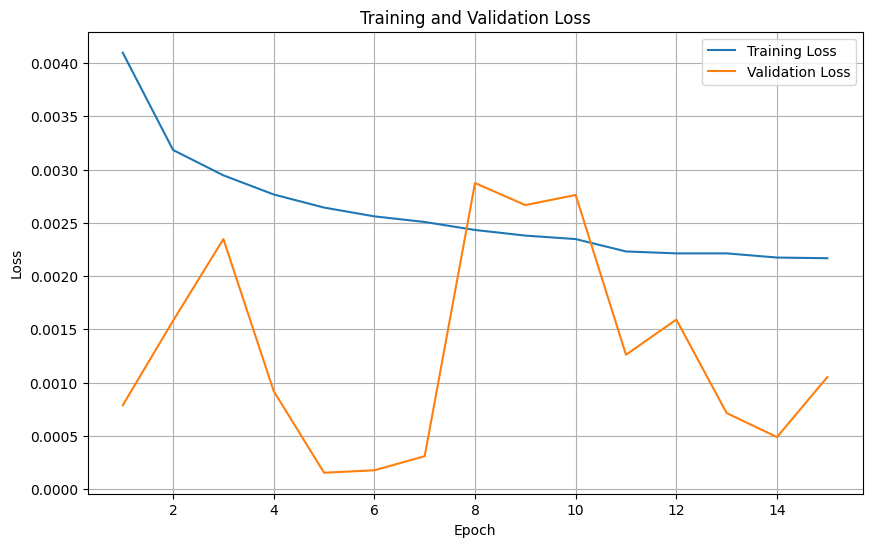

In [64]:
train_losses = new_tft_lightning_module.train_losses_per_epoch
val_losses = new_tft_lightning_module.validation_losses_per_epoch

# Create epoch array
epochs = range(1, len(train_losses) + 1)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig(f"{GOOGLE_DRIVE_PATH}/models_results/checkpoints/ydosi3-tft-v8-loss-curve.png")

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


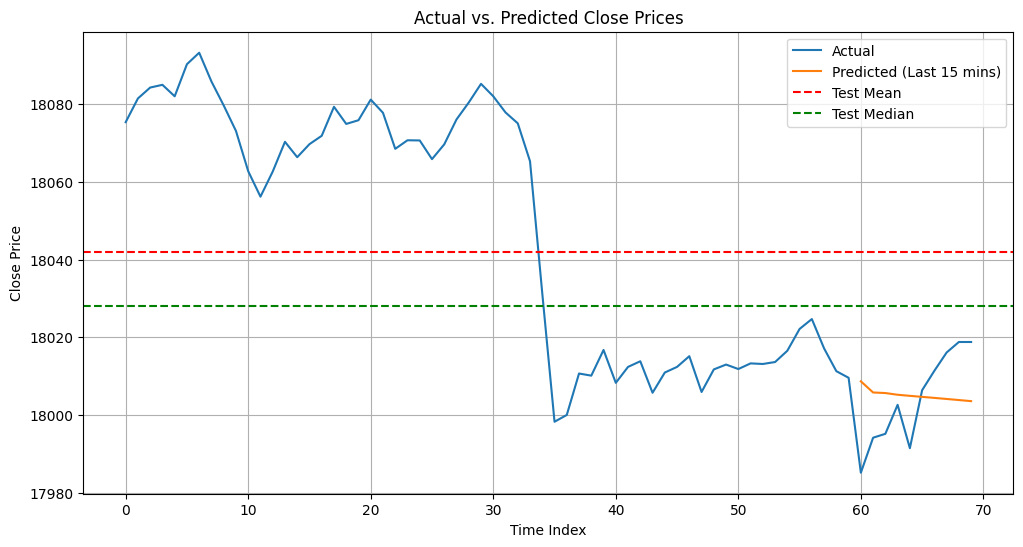

In [65]:
start = 1000
input_context = 60
test_df1 = test_df[start:start+max_prediction_length+input_context]  # Select data from index 10001 to 10030 (30 minutes)

test_data = TimeSeriesDataSet.from_dataset(
    training_data,
    test_df1,
    predict=True,
    stop_randomization=True,
    # min_encoder_length=24,
    # max_encoder_length=24,
    # min_prediction_length=6,
    # max_prediction_length=6
)

test_dataloader = test_data.to_dataloader(batch_size=1, num_workers=0, train=False)

# Get predictions
predictions = best_model.model.predict(test_dataloader)
# raw_predictions = tft.predict(test_dataloader, mode="raw", return_x=True, trainer_kwargs=dict(accelerator="cpu"))

predicted_close = predictions  # Example: Assuming a single output

# Determine the indices for the last 15 minutes of predictions
prediction_indices = range(input_context, len(test_df1))
actual_indices = range(0, len(test_df1))

# Plot actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(actual_indices, test_df1['close'], label='Actual')
plt.plot(list(prediction_indices), predicted_close.tolist()[0], label='Predicted (Last 15 mins)')
# add horizontal line
plt.axhline(y=test_df1['close'].mean(), color='r', linestyle='--', label='Test Mean')
plt.axhline(y=test_df1['close'].median(), color='g', linestyle='--', label='Test Median')
# plt.axhline(y=train_df['close'].mean(), linestyle=':', label='Train Mean')
# plt.axhline(y=train_df['close'].median(), linestyle='-.', label='Train Median')
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.title("Actual vs. Predicted Close Prices")
plt.legend()
plt.grid(True)
plt.savefig(f"{GOOGLE_DRIVE_PATH}/models_results/checkpoints/ydosi3-tft-v8-sample-pred-1000.png")


In [66]:
# # raw predictions
raw_preds = best_model.model.predict(test_dataloader, mode="raw", return_x=True)

# # plot raw predictions
# best_model.model.plot_prediction(x=raw_preds.x, out=raw_preds.output, idx=0, add_loss_to_title=True)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [43]:
# predictions_vs_actuals = best_model.model.calculate_prediction_actual_by_variable(
#     raw_preds.x, raw_preds.output["prediction"]
# )

# plts = best_model.model.plot_prediction_actual_by_variable(predictions_vs_actuals)

In [44]:
# plts.keys()

In [45]:
# plts['vix_close']

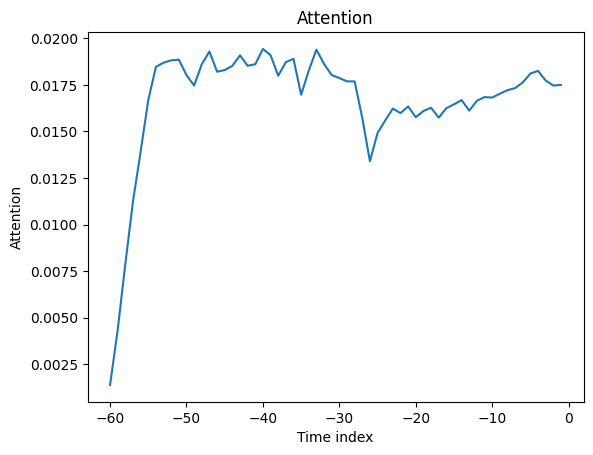

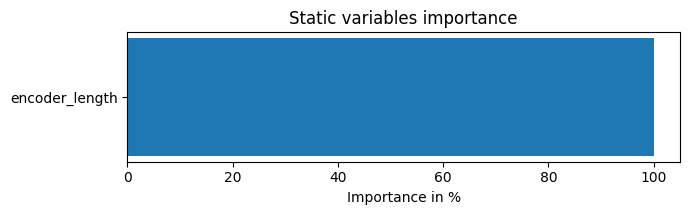

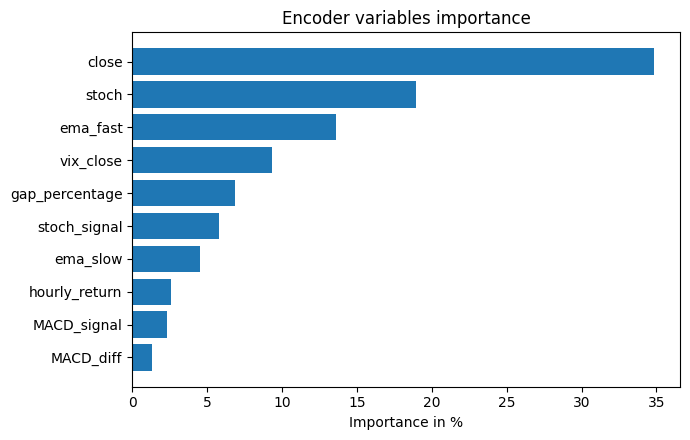

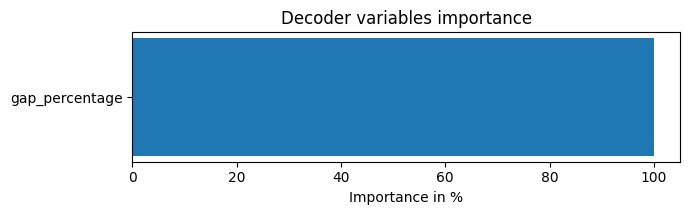

In [67]:
interpretation = best_model.model.interpret_output(raw_preds.output, reduction="sum")
int_plts = best_model.model.plot_interpretation(interpretation)

In [68]:
int_plts.keys()

dict_keys(['attention', 'static_variables', 'encoder_variables', 'decoder_variables'])

In [69]:
int_plts['attention'].savefig(f"{GOOGLE_DRIVE_PATH}/models_results/checkpoints/ydosi3-tft-v8-attn-weights.png")

In [70]:
int_plts['encoder_variables'].savefig(f"{GOOGLE_DRIVE_PATH}/models_results/checkpoints/ydosi3-tft-v8-variable-importance.png")

In [71]:
def run_model_prediction(model, pred_input_df):
    """
    - preds: torch.Tensor of shape (1, pred_len, num_quantiles)
    """
    test_data = TimeSeriesDataSet.from_dataset(
        training_data,
        pred_input_df,
        predict=True,
        stop_randomization=True,
        # min_encoder_length=24,
        # max_encoder_length=24,
        # min_prediction_length=6,
        # max_prediction_length=6
    )

    test_dataloader = test_data.to_dataloader(batch_size=1, num_workers=0, train=False)

    # Get predictions
    predictions = best_model.model.predict(test_dataloader)
    return predictions

def reshape_forecast_for_cnn(forecast_tensor):
    """
    Input: forecast_tensor of shape (1, T, Q) or (T, Q=3)
    Output: reshaped tensor of shape (T, 4) for CNN
    """
    if isinstance(forecast_tensor, np.ndarray):
        forecast_np = forecast_tensor
    else:
        forecast_np = forecast_tensor.detach().cpu().numpy()

    if forecast_np.ndim == 3:
        forecast_np = forecast_np.squeeze(0)  # (T, Q)

    # Add 4th channel (mean of quantiles)
    #avg_col = np.mean(forecast_np, axis=-1, keepdims=True)
    #cnn_input = np.concatenate([forecast_np, avg_col], axis=-1)  # (T, 4)
    #print(cnn_input)
    return torch.tensor(forecast_np, dtype=torch.float32)

In [72]:
def calculate_z_score(df, column, lookback_window):
    if column not in df.columns:
        raise ValueError(f"Column '{column}' does not exist in the DataFrame.")

    # Calculate the rolling mean and standard deviation
    rolling_mean = df[column].rolling(window=lookback_window).mean()
    rolling_std = df[column].rolling(window=lookback_window).std()

    # Calculate the Z-score
    df['zscore'] = (df[column] - rolling_mean) / rolling_std
    return df


def enrich_tensor_cnn(close_tensor):
    B, window, _ = close_tensor.shape
    enriched = []

    for i in range(B):
        close = close_tensor[i, :, 0].cpu().numpy()
        df = pd.DataFrame({'close': close})

        # Calculate indicators
        df["ema"] = ta.trend.EMAIndicator(merged_data['close'], window=15).ema_indicator()
        df["rsi"] = ta.momentum.RSIIndicator(merged_data['close'], window=15).rsi()
        calculate_z_score(df, 'close', lookback_window=15)

        df.bfill(inplace=True)
        df.fillna(0, inplace=True)

        enriched.append(df[['close','ema','rsi','zscore']].values)

    enriched_tensor = torch.tensor(np.stack(enriched), dtype=torch.float32).to(close_tensor.device)
    return enriched_tensor


In [73]:
from MarketSimulator import *
# from src.forecasting.Scalers import enrich_tensor_cnn
from utils.classify_window import classify_window

WINDOW_SIZE = 10
PATTERN_LABELS = ['head_and_shoulders', 'double_bottom', 'ascending_triangle', 'none']

def extract_windows(df, seq_len, step_size):
    windows = []
    for start in range(0, len(df) - seq_len + 1, step_size):
        end = start + seq_len
        window = df.iloc[start:end].copy()
        windows.append(window)
    return windows

num_days = 10
trading_hrs = 6.5
simulation_data_size = int(60 * trading_hrs * num_days) # minutes * hrs * days
window_seq_length = 70
step_size = WINDOW_SIZE

# Start at index 0 and then slide the window of size(WINDOW_SIZE) by step_size steps
simulation_windows = extract_windows(test_df, window_seq_length, step_size)

simulation_data = []

for fcast in simulation_windows:

    classified_forecast = dict()

    #forecast = run_model_prediction(model, scaler, fcast,feature_cols, window_seq_length)
    # fcast_tensor = torch.tensor(fcast['close'].values, dtype=torch.float32)
    # fcast_tensor = fcast_tensor.unsqueeze(0).unsqueeze(2)

    forecast = run_model_prediction(best_model.model, fcast)
    classified_forecast['window'] = fcast['close']
    classified_forecast['forecast'] = forecast.unsqueeze(2).cpu()
    classified_forecast['label'] = classify_window(
        reshape_forecast_for_cnn(enrich_tensor_cnn(forecast.unsqueeze(2))),
        model_type='1d',
        model_path=f"{GOOGLE_DRIVE_PATH}/models_results/checkpoints/CNN1D_MULTICHANNEL.pt",
        PATTERN_LABELS=PATTERN_LABELS)
    simulation_data.append(classified_forecast)


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators

In [78]:
trader = Trader()

# have to use a very high price tolerance as the forecast is way off the actual close price
simulator = MarketSimulator(processed_data=simulation_data, initial_budget=100000, price_tolerance=1000)

trade_log = simulator.simulate()

In [ ]:
trade_log

In [ ]:
trade_log_df = pd.DataFrame(trade_log, columns=['idx', 'signal', 'price', 'portfolio'])
trade_log_df.head()

In [ ]:
log_file_path = f"{GOOGLE_DRIVE_PATH}/models_results/checkpoints/ydosi3-tft-trade-v8-1dconv.log"
trade_log_df.to_csv(log_file_path, index=False)  # Save to CSV, without the index
print(f"Trade log saved to: {log_file_path}")